# 01. Data Overview

**Purpose:** Load experiment data, validate quality, and understand experiment coverage.

**Key Questions:**
- How many experiments do we have?
- What's the distribution across models, datasets, and RAG components?
- Are there any data quality issues?

In [1]:
from analysis_utils import (
    load_all_results, setup_plotting,
    METRICS, PRIMARY_METRIC, DEFAULT_STUDY_PATH
)
import pandas as pd
import matplotlib.pyplot as plt

setup_plotting()

# Load data
df = load_all_results()
print(f"Loaded {len(df)} experiments from {DEFAULT_STUDY_PATH}")

Loaded 136 experiments from ../outputs/smart_retrieval_slm


## 1.1 Data Quality Check

In [2]:
if len(df) > 0:
    print("Data Quality Check")
    print("=" * 60)
    
    # Check for unknown datasets
    unknown_ds = df[df['dataset'] == 'unknown']
    if len(unknown_ds) > 0:
        print(f"\n⚠️ {len(unknown_ds)} experiments with 'unknown' dataset")
    else:
        print("\n✅ All experiments have known datasets")
    
    # Check for unknown models
    unknown_model = df[df['model_short'] == 'unknown']
    if len(unknown_model) > 0:
        print(f"⚠️ {len(unknown_model)} experiments with 'unknown' model")
    else:
        print("✅ All experiments have known models")
    
    # Check for missing metrics
    missing_metric = df[PRIMARY_METRIC].isna()
    if missing_metric.sum() > 0:
        print(f"⚠️ {missing_metric.sum()} experiments missing {PRIMARY_METRIC}")
    else:
        print(f"✅ All experiments have {PRIMARY_METRIC} metric")
    
    # Available metrics
    available_metrics = [m for m in METRICS if m in df.columns and df[m].notna().sum() > 0]
    print(f"\nAvailable metrics: {available_metrics}")

Data Quality Check

✅ All experiments have known datasets
✅ All experiments have known models
⚠️ 4 experiments missing f1

Available metrics: ['f1', 'exact_match', 'bleurt']


## 1.2 Experiment Distribution

In [3]:
if len(df) > 0:
    print("Experiment Distribution")
    print("=" * 60)
    
    # Experiment types
    print(f"\nExperiment types: {df['exp_type'].value_counts().to_dict()}")
    
    # By key dimensions
    dimensions = ['model_short', 'dataset', 'retriever_type', 'embedding_model', 
                  'query_transform', 'reranker', 'prompt']
    
    for dim in dimensions:
        if dim in df.columns:
            counts = df[dim].value_counts()
            if len(counts) > 0:
                print(f"\n{dim}:")
                for val, count in counts.items():
                    print(f"  {val}: {count}")

Experiment Distribution

Experiment types: {'rag': 118, 'direct': 18}

model_short:
  Qwen-2.5-3B: 48
  Llama-3.2-3B: 46
  Phi-3-mini: 42

dataset:
  hotpotqa: 49
  nq: 47
  triviaqa: 40

retriever_type:
  dense: 59
  hybrid: 42
  hierarchical: 17

embedding_model:
  BGE-large: 56
  GTE-Qwen2-1.5B: 43
  BGE-M3: 19

query_transform:
  none: 66
  hyde: 41
  multiquery: 29

reranker:
  none: 103
  bge-v2: 33

prompt:
  concise: 62
  fewshot_3: 33
  cot: 21
  structured: 20


## 1.3 Configuration Coverage Matrix

RAG Experiments: Model × Dataset Coverage


dataset,hotpotqa,nq,triviaqa
model_short,,,
Llama-3.2-3B,15,15,10
Phi-3-mini,12,17,7
Qwen-2.5-3B,16,9,17


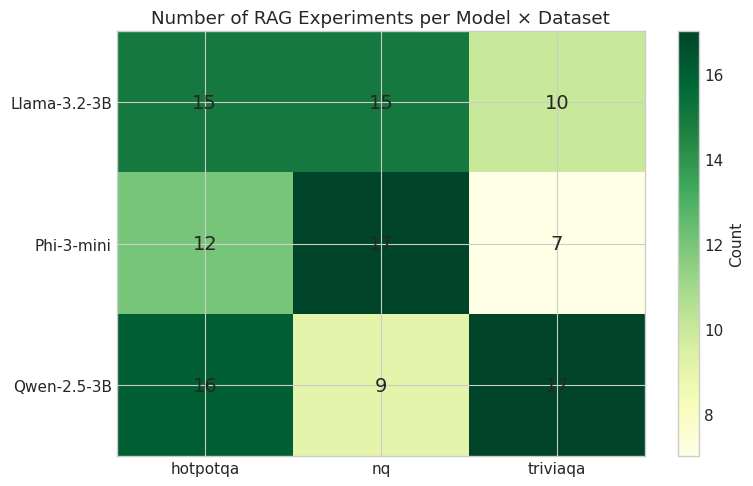

In [4]:
if len(df) > 0:
    rag_df = df[df['exp_type'] == 'rag']
    
    if len(rag_df) > 0 and 'model_short' in rag_df.columns and 'dataset' in rag_df.columns:
        # Model × Dataset coverage
        coverage = rag_df.groupby(['model_short', 'dataset']).size().unstack(fill_value=0)
        
        print("RAG Experiments: Model × Dataset Coverage")
        print("=" * 60)
        display(coverage)
        
        # Visualization
        fig, ax = plt.subplots(figsize=(8, 5))
        im = ax.imshow(coverage.values, cmap='YlGn', aspect='auto')
        
        ax.set_xticks(range(len(coverage.columns)))
        ax.set_xticklabels(coverage.columns)
        ax.set_yticks(range(len(coverage.index)))
        ax.set_yticklabels(coverage.index)
        
        # Add text annotations
        for i in range(len(coverage.index)):
            for j in range(len(coverage.columns)):
                ax.text(j, i, coverage.values[i, j], ha='center', va='center', fontsize=14)
        
        ax.set_title('Number of RAG Experiments per Model × Dataset')
        plt.colorbar(im, ax=ax, label='Count')
        plt.tight_layout()
        plt.show()

## 1.4 Performance Overview

Performance Overview (f1)

DIRECT:
  Count: 18
  Mean:  0.1446
  Std:   0.1639
  Min:   0.0064
  Max:   0.5664

RAG:
  Count: 114
  Mean:  0.1069
  Std:   0.1379
  Min:   0.0049
  Max:   0.5492


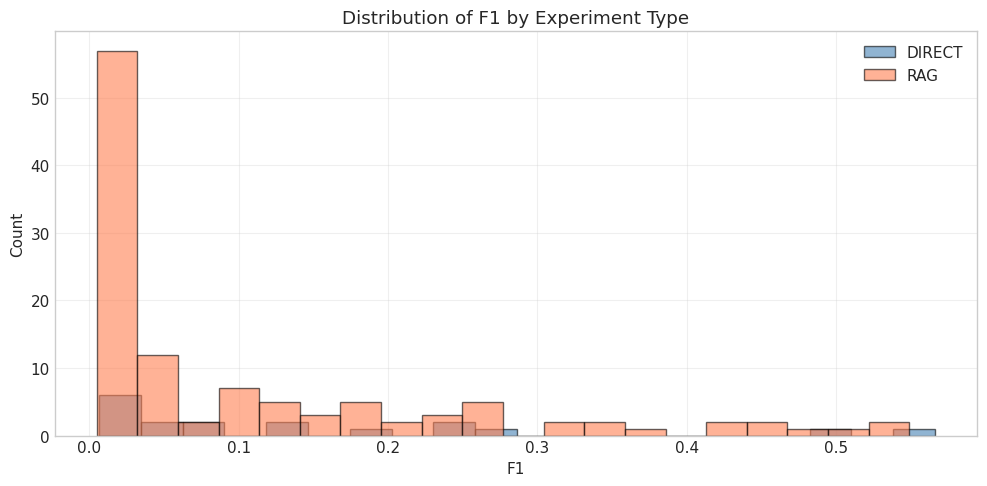

In [5]:
if len(df) > 0 and PRIMARY_METRIC in df.columns:
    print(f"Performance Overview ({PRIMARY_METRIC})")
    print("=" * 60)
    
    # Summary statistics
    for exp_type in ['direct', 'rag']:
        subset = df[df['exp_type'] == exp_type][PRIMARY_METRIC].dropna()
        if len(subset) > 0:
            print(f"\n{exp_type.upper()}:")
            print(f"  Count: {len(subset)}")
            print(f"  Mean:  {subset.mean():.4f}")
            print(f"  Std:   {subset.std():.4f}")
            print(f"  Min:   {subset.min():.4f}")
            print(f"  Max:   {subset.max():.4f}")
    
    # Distribution plot
    fig, ax = plt.subplots(figsize=(10, 5))
    
    for exp_type, color in [('direct', 'steelblue'), ('rag', 'coral')]:
        subset = df[df['exp_type'] == exp_type][PRIMARY_METRIC].dropna()
        if len(subset) > 0:
            ax.hist(subset, bins=20, alpha=0.6, color=color, label=exp_type.upper(), edgecolor='black')
    
    ax.set_xlabel(PRIMARY_METRIC.upper())
    ax.set_ylabel('Count')
    ax.set_title(f'Distribution of {PRIMARY_METRIC.upper()} by Experiment Type')
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

## 1.5 Summary

**Key Findings:**
- Total experiments loaded
- Data quality status
- Coverage gaps to address

In [6]:
if len(df) > 0:
    print("SUMMARY")
    print("=" * 60)
    print(f"Total experiments: {len(df)}")
    print(f"  - Direct: {len(df[df['exp_type'] == 'direct'])}")
    print(f"  - RAG: {len(df[df['exp_type'] == 'rag'])}")
    print(f"\nModels: {sorted(df['model_short'].unique().tolist())}")
    print(f"Datasets: {sorted(df['dataset'].unique().tolist())}")
    
    if 'retriever_type' in df.columns:
        print(f"Retriever types: {df['retriever_type'].dropna().unique().tolist()}")

SUMMARY
Total experiments: 136
  - Direct: 18
  - RAG: 118

Models: ['Llama-3.2-3B', 'Phi-3-mini', 'Qwen-2.5-3B']
Datasets: ['hotpotqa', 'nq', 'triviaqa']
Retriever types: ['dense', 'hybrid', 'hierarchical']
